_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

## Imports and initial data exploration

In [2]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0


In [4]:
df.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.395800e+04,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,2.442837e+07,270.438458,2.412380,4.727540,28.506376,17.600373,-0.554162,131.257988,0.472919,1.615561
std,7.226620e+06,169.927170,1.125828,3.331646,17.597701,10.295807,124.721869,102.666562,0.499284,10.127139
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120091e+07,109.000000,1.000000,2.000000,13.000000,8.000000,-96.000000,23.000000,0.000000,-4.000000
50%,2.150026e+07,275.500000,2.000000,4.000000,29.000000,22.000000,1.000000,141.000000,0.000000,1.000000
75%,2.170096e+07,398.000000,3.000000,7.000000,44.000000,25.000000,95.000000,219.000000,1.000000,8.000000
max,4.180040e+07,752.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


In [5]:
df.describe(exclude='number')

,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,htm,vtm,season_type
count,13958,13958,13958,13958,13958,13958,13958,13958,13958
unique,1,53,2,7,6,5,32,32,2
top,Stephen Curry,Jump Shot,2PT Field Goal,Above the Break 3,Center(C),24+ ft.,GSW,GSW,Regular Season
freq,13958,6657,7135,5695,5987,6721,6871,7087,11846


In [6]:
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

In [7]:
df['home_court'] = df.htm=='GSW'

In [8]:
def opponent_helper(row):
    if row['htm'] == 'GSW':
        val = row['vtm']
    else:
        val = row['htm']
    return val

In [9]:
df['opponent'] = df.apply(opponent_helper, axis=1)

In [10]:
df['seconds_remaining_period'] = (df.minutes_remaining*60) + df.seconds_remaining

In [11]:
df['seconds_remaining_game'] = ((4-df.period)*720) + df.seconds_remaining_period

In [12]:
df['made_previous_shot'] = df.shot_made_flag.shift(1).fillna(0)

In [13]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,home_court,opponent,seconds_remaining_period,seconds_remaining_game,made_previous_shot
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,0,GSW,HOU,Regular Season,2.0,True,HOU,685,2845,0.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,1,GSW,HOU,Regular Season,0.0,True,HOU,571,2731,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,0,GSW,HOU,Regular Season,-4.0,True,HOU,362,2522,1.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,0,GSW,HOU,Regular Season,-4.0,True,HOU,589,2029,0.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,0,GSW,HOU,Regular Season,0.0,True,HOU,139,1579,0.0


## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.

In [14]:
# train/test/validate split
train = df[:'2017-06-13']
test = df['2017-06-13':'2018-06-09']
val = df['2018-06-09':]

In [15]:
# the number of observations shows I've split the data correctly
train.shape, test.shape, val.shape

((11081, 24), (1168, 24), (1709, 24))

In [16]:
# the split dataframes add up to the original df size
11081+1168+1709

13958

2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?

In [17]:
# baseline: assume he missed every shot. 52.7% accuracy
df['shot_made_flag'].value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

In [18]:
target = 'shot_made_flag'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features and categorical features to use in the model
# I'm dropping player_name since it's always the same
# Dropping htm, vtm, minutes_remaining and second_remaining because they're 
# redundant now that I've used them to engineer better features
numeric_features = [
    'game_id',
    'game_event_id',
    'period',
    'shot_distance',
    'loc_x',
    'loc_y',
    'scoremargin_before_shot',
    'seconds_remaining_period',
    'seconds_remaining_game',
    'made_previous_shot']
categorical_features = [
    'action_type',
    'shot_type',
    'shot_zone_basic',
    'shot_zone_area',
    'shot_zone_range',
    'season_type',
    'home_court',
    'opponent']

# Combine the lists 
features = numeric_features + categorical_features

In [19]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [20]:
# Create a pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=800, max_depth=25)
)

# Fit on train, score on validation
pipeline.fit(X_train, y_train)
print(f'Validation Score: {pipeline.score(X_val, y_val)}')

Validation Score: 0.6360444704505559


## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)

In [21]:
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

Validation Accuracy: 0.6360444704505559


2. Get your model's **test accuracy.** (One time, at the end.)

In [22]:
print(f'Test Accuracy: {pipeline.score(X_test, y_test)}')

Test Accuracy: 0.610445205479452


3. Get and plot your Random Forest's **feature importances**

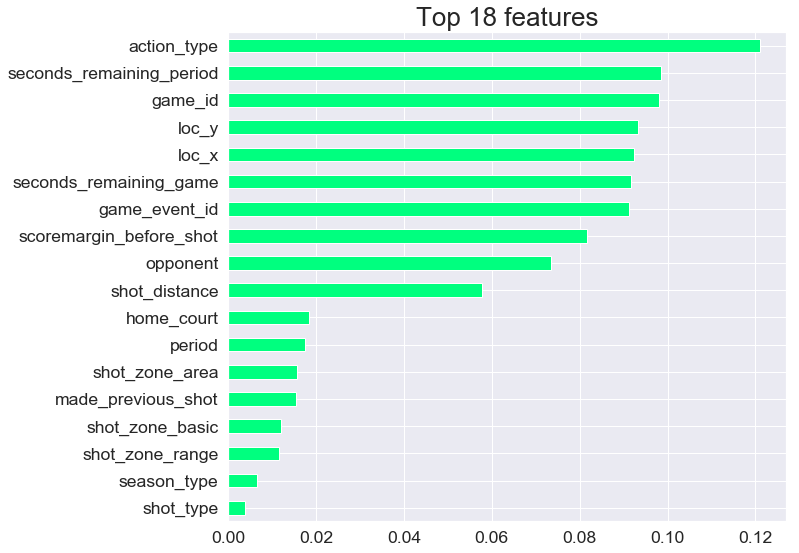

In [33]:
# Get feature importances
encoder = pipeline.named_steps['ordinalencoder']
tree = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
sns.set_style('darkgrid')
n = 18
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features', fontsize=26)
importances.sort_values()[-n:].plot.barh(color='springgreen');

4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>



In [24]:
# accuracy
correct_predictions = 85 + 36 
total_predictions = 85 + 58 + 8 + 36
matrix_accuracy = correct_predictions/total_predictions
matrix_accuracy

0.6470588235294118

In [25]:
# Negative precision
total_negative_preds = 85 + 8
correct_negative_preds = 85
negative_precision = correct_negative_preds/total_negative_preds
negative_precision

0.9139784946236559

In [26]:
# Positive precision
total_positive_preds = 58 + 36
correct_positive_preds = 36
positive_precision = correct_positive_preds/total_positive_preds
positive_precision

0.3829787234042553

In [27]:
# Negative recall
total_neg = 85 + 58
predicted_neg = 85
negative_recall = predicted_neg/total_neg
negative_recall

0.5944055944055944

In [28]:
# Positive recall
# Positive has better recall and worse precision
total_pos = 8 + 36
predicted_pos = 36
positive_recall = predicted_pos/total_pos
positive_recall

0.8181818181818182

### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.

In [29]:
negative_F1 = 2 * (negative_precision * negative_recall) / (negative_precision + negative_recall)
positive_F1 = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall)
print(f'Negative F1: {negative_F1}')
print(f'Positive F1: {positive_F1}')

Negative F1: 0.7203389830508474
Positive F1: 0.5217391304347826


- Plot a real confusion matrix for your basketball model, with row and column labels.

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array([0, 1], dtype=int64)

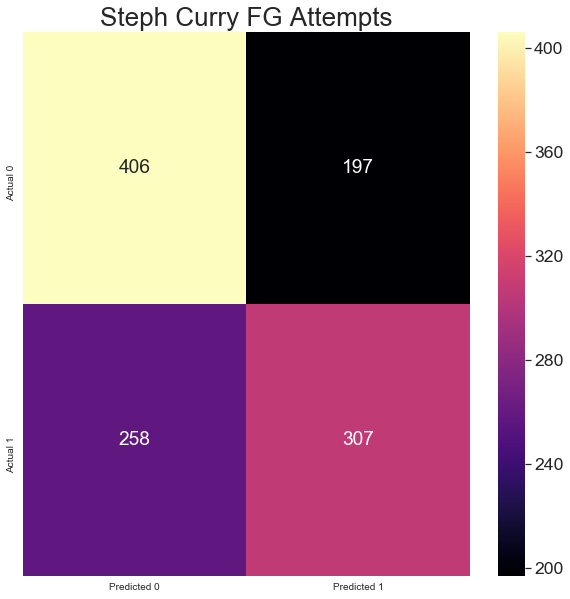

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
plt.title('Steph Curry FG Attempts', fontsize=26)
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                        columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='magma')

plot_confusion_matrix(y_test, pipeline.predict(X_test));

- Print the classification report for your model.

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       603
           1       0.61      0.54      0.57       565

   micro avg       0.61      0.61      0.61      1168
   macro avg       0.61      0.61      0.61      1168
weighted avg       0.61      0.61      0.61      1168

